<div style="background-image: linear-gradient(to right, #4b4cff , #00d4ff); text-align: center; padding: 50px;">
  <h1 style="font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; font-size: 48px; color: white; text-shadow: 2px 2px #4b4cff;">
    NLP Twitter Analysis
  </h1>
</div>

<h2 style="color:#f7ce5b; font-family: Arial, sans-serif; font-size: 40px; margin-top: 50px; border-bottom: 2px solid #f7ce5b;">
Library
</h2>

In [11]:
import pandas as pd
import numpy as np 
import re 
import string
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import spacy

from sklearn import metrics
from sklearn.metrics import confusion_matrix,roc_auc_score,classification_report
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier,ExtraTreesClassifier
from sklearn.linear_model import RidgeClassifier,SGDClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

/Users/pierre/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pierre/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

<h2 style="color:#f7ce5b; font-family: Arial, sans-serif; font-size: 40px; margin-top: 50px; border-bottom: 2px solid #f7ce5b;">
Data
</h2>

In [15]:
column_names=['Tweet_ID','Entity','Sentiment','Tweet_content']

train_data = pd.read_csv("./data/twitter_training.csv", sep=',',names=column_names)

val_data = pd.read_csv("./data/twitter_validation.csv", sep=',',names=column_names)

It s multiclass classification problem. 

In [21]:
train_data.isna().sum()

Tweet_ID           0
Entity             0
Sentiment          0
Tweet_content    686
dtype: int64

I don't know for the moment if I want to keep empty tweets or not. Maybe it will have a big impact on the 'Irrelevant' categorie.

In [27]:
train_data.fillna('', inplace = True)
val_data.fillna('', inplace = True)

In [23]:
train_data.isna().sum()

Tweet_ID         0
Entity           0
Sentiment        0
Tweet_content    0
dtype: int64

We have to clean up the tweets.

In [24]:
def remove_urls(text):
    """Berilgan matndan URL larini o'chiradi"""
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)


def remove_emojis(text):
    """Berilgan matndan emojilarni o'chiradi"""
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  
                               u"\U0001F300-\U0001F5FF"  
                               u"\U0001F680-\U0001F6FF"  
                               u"\U0001F1E0-\U0001F1FF"  
                               u"\U00002702-\U000027B0"  
                               u"\U000024C2-\U0001F251"  
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [25]:
train_data['Tweet_content'] = train_data['Tweet_content'].apply(lambda x: remove_emojis(x))
train_data['Tweet_content'] = train_data['Tweet_content'].apply(lambda x: remove_urls(x))

val_data['Tweet_content'] = val_data['Tweet_content'].apply(lambda x: remove_emojis(x))
val_data['Tweet_content'] = val_data['Tweet_content'].apply(lambda x: remove_urls(x))

In [29]:
train_data['text_lens'] = train_data['Tweet_content'].apply(lambda x: len(x))
val_data['text_lens'] = val_data['Tweet_content'].apply(lambda x: len(x))

In [33]:
sentiment_counts = train_data['Sentiment'].value_counts()
sentiment_counts

Negative      22542
Positive      20832
Neutral       18318
Irrelevant    12990
Name: Sentiment, dtype: int64

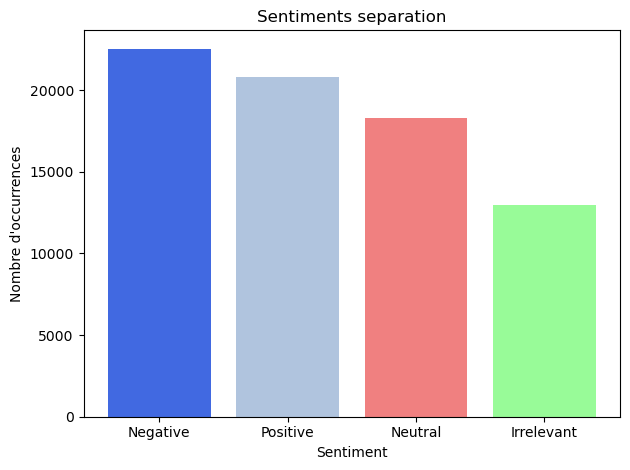

In [35]:
colors = ['royalblue', 'lightsteelblue', 'lightcoral', 'palegreen']
plt.bar(sentiment_counts.index, sentiment_counts.values, color=colors)

plt.xlabel('Sentiment')
plt.ylabel('Nombre d\'occurrences')
plt.title('Sentiments separation')

plt.tight_layout()
plt.show()

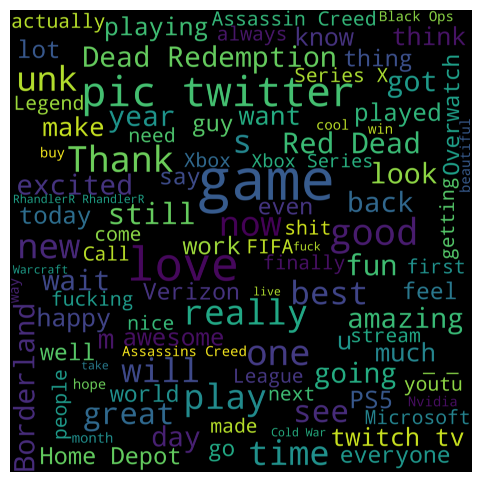

In [38]:
word_cloud_text = ''.join(train_data[train_data["Sentiment"]=="Positive"].Tweet_content)
wordcloud = WordCloud(
    max_font_size=100,
    max_words=100,
    background_color="black",
    scale=10,
    width=800,
    height=800
).generate(word_cloud_text)
#Figure properties
plt.figure(figsize=(6,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

<h2 style="color:#f7ce5b; font-family: Arial, sans-serif; font-size: 40px; margin-top: 50px; border-bottom: 2px solid #f7ce5b;">
Preprocessing
</h2>

In [41]:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

train = remove_outlier(train_data,'text_lens')

In [44]:
import spacy

nlp=spacy.load('en_core_web_sm')

def preprocess(text):
    doc = nlp(text)
    filtered_tokens=[]
    for token in doc:
        if not token.is_stop and not token.is_punct:
            filtered_tokens.append(token.lemma_)
    return " ".join(filtered_tokens)
    
train_data['preprocessed_text']=train_data['Tweet_content'].apply(lambda x: preprocess(x))
val_data['preprocessed_text']=val_data['Tweet_content'].apply(lambda x: preprocess(x))

In [47]:
from sklearn.model_selection import train_test_split

X_train ,X_test , y_train, y_test = train_test_split(
    train_data[['preprocessed_text']],
    train_data[['Sentiment']],
    test_size=0.2,
    random_state=42
)

In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer= TfidfVectorizer()

X_train_vect = vectorizer.fit_transform(X_train['preprocessed_text'])
X_test_vect = vectorizer.transform(X_test['preprocessed_text'])

y_train = y_train['Sentiment'].map({"Positive":0,"Negative":1,"Neutral":2,"Irrelevant":3})
y_test = y_test['Sentiment'].map({"Positive":0,"Negative":1,"Neutral":2,"Irrelevant":3})

In [50]:
validation_X = vectorizer.transform(val_data['preprocessed_text'])
validation_y = val_data['Sentiment'].map({"Positive":0,"Negative":1,"Neutral":2,"Irrelevant":3})

<h2 style="color:#f7ce5b; font-family: Arial, sans-serif; font-size: 40px; margin-top: 50px; border-bottom: 2px solid #f7ce5b;">
Machine Learning
</h2>

In [52]:
model = MultinomialNB()
model.fit(X_train_vect,y_train)

y_predict= model.predict(X_test_vect)
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

           0       0.72      0.80      0.76      4230
           1       0.65      0.90      0.75      4519
           2       0.82      0.63      0.71      3596
           3       0.95      0.45      0.61      2592

    accuracy                           0.73     14937
   macro avg       0.78      0.69      0.71     14937
weighted avg       0.76      0.73      0.72     14937



In [53]:
model = RandomForestClassifier()
model.fit(X_train_vect,y_train)

y_predict= model.predict(X_test_vect)

print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90      4230
           1       0.93      0.92      0.92      4519
           2       0.84      0.93      0.88      3596
           3       0.96      0.84      0.90      2592

    accuracy                           0.90     14937
   macro avg       0.91      0.90      0.90     14937
weighted avg       0.91      0.90      0.90     14937



In [54]:
model_extra = ExtraTreesClassifier()
model_extra.fit(X_train_vect,y_train)

y_predict= model_extra.predict(X_test_vect)

print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

           0       0.92      0.91      0.92      4230
           1       0.94      0.93      0.94      4519
           2       0.86      0.94      0.90      3596
           3       0.97      0.87      0.92      2592

    accuracy                           0.92     14937
   macro avg       0.92      0.91      0.92     14937
weighted avg       0.92      0.92      0.92     14937



## Validation

In [55]:
y_predict= model_extra.predict(validation_X)
print(classification_report(validation_y,y_predict))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       277
           1       0.96      0.98      0.97       266
           2       0.97      0.97      0.97       285
           3       0.99      0.95      0.97       172

    accuracy                           0.97      1000
   macro avg       0.97      0.97      0.97      1000
weighted avg       0.97      0.97      0.97      1000



We got pretty cool results with this model.

In [57]:
import pickle
with open('./model/model_extra.pkl', 'wb') as file:
    pickle.dump(model_extra, file)
    
with open('./model/vectorizer.pkl', 'wb') as file:
    pickle.dump(vectorizer, file)

We have now our model ready to predict, I have to create a test tweet and treat this tweet in order to predict the answer.